In [41]:
pip install qiskit[visualization] qiskit-ibm-runtime qiskit-aer qiskit-aer-gpu jupyter matplotlib

  Using cached qiskit_ibm_runtime-0.29.0-py3-none-any.whl (2.9 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.3/434.3 KB 2.5 MB/s eta 0:00:002.4 MB/s eta 0:00:01
  Using cached ibm_platform_services-0.57.0-py3-none-any.whl (343 kB)
  Using cached requests_ntlm-1.3.0-py3-none-any.whl (6.6 kB)
  Using cached ibm_cloud_sdk_core-3.20.6-py3-none-any.whl (60 kB)
  Using cached annotated_types-0.7.0-py3-none-any.whl (13 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 17.0 MB/s eta 0:00:0031m16.4 MB/s eta 0:00:01
  Using cached cryptography-43.0.1-cp39-abi3-manylinux_2_28_x86_64.whl (4.0 MB)
  Using cached pyspnego-0.11.1-py3-none-any.whl (130 kB)
  Using cached PyJWT-2.9.0-py3-none-any.whl (22 kB)
Note: you may need to restart the kernel to use updated packages.


In [6]:
#Import Modules
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator

from matplotlib import pyplot as plt

In [7]:
#TODO - Create Quantum Noise Model

In [8]:
#Create a Bell state circuit, maps to 2 qubits
def get_bell_circ():
    #Create a circuit to perform entanglement
    b_circ = QuantumCircuit(2, name = "To Bell State")

    #Prepare a bell state of both qubits, qubit 0 to hadamard state, do
    #x-control of qubit 1 by qubit 0
    b_circ.h(0)
    b_circ.cx(0,1)

    #Return the bell state circuit
    return b_circ

In [9]:
#Create a 2-bit encoding circuit, maps to 1-qubit
def get_encode_circ(message):
    #Create the encoder circuit
    e_circ = QuantumCircuit(1, name = "Information Encoder")

    #Flip the phase of the qubit and rotate about the x-axis 180 deg if message is 11
    if (message & 0b11 == 0b11):
        e_circ.z(0)
        e_circ.x(0)

    #If the message is 10, rotate 180 degrees about the x-axis
    elif (message & 0b11 == 0b10):
        e_circ.x(0)

    #If the message is 01, flip the phase
    elif (message & 0b11 == 0b01):
        e_circ.z(0)

    #Return the encoder circuit
    return e_circ

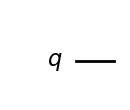

In [10]:
#Create Encoding Circuit instance, should be straight wire, I
ec00 = get_encode_circ(0b00)
ec00.draw('mpl')

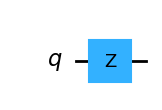

In [11]:
#Create Encoding Circuit instance, should be inversion of phase
ec01 = get_encode_circ(0b01)
ec01.draw('mpl')

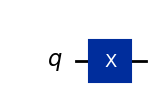

In [12]:
#Create Encoding Circuit instance, should be 
ec10 = get_encode_circ(0b10)
ec10.draw('mpl')

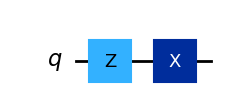

In [13]:
#Create Encoding Circuit instance
ec11 = get_encode_circ(0b11)
ec11.draw('mpl')

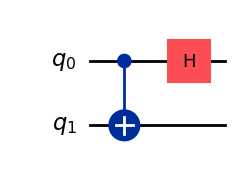

In [14]:
#Create a 2-bit decoding circuit, maps to 2-qubits
def get_decode_circ():
    #Create the decoder circuit
    d_circ = QuantumCircuit(2, name = "Information Decoder")

    #Un-entangle the qubits, and use the hadamard gate 
    d_circ.cx(0, 1)
    d_circ.h(0)

    #Return the decoder circuit
    return d_circ

#Create Decoding Circuit instance, draw
dc = get_decode_circ()
dc.draw('mpl')

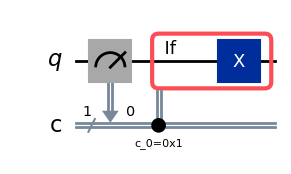

In [15]:
#Create reset circuit, maps to 1-qubit and 1-classical bit, collapses state
def get_reset_circ():
    #Create the reset circuit
    r_circ = QuantumCircuit(1, 1, name = "Reset To 0")

    #Measure to collapse the state and store in the classical_bit
    r_circ.measure(0, 0)

    #If the classical bit is measured as 1, return the qubit to 0
    with r_circ.if_test((0, 1)):
        r_circ.x(0)

    #Return the reset circuit
    return r_circ

#Create Reset Circuit instance, draw with mpl, the other doesn't visualize well
rc = get_reset_circ()
rc.draw('mpl')

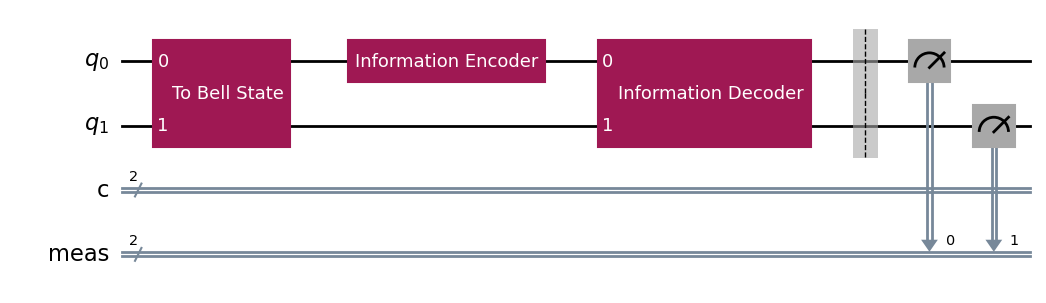

In [17]:
#Create superdense coding circuit
def get_sdc_circ(message):
    #Create the superdense coding circuit
    sdc_circ = QuantumCircuit(2, 2, name = "Superdense Coding Circuit")

    #Prepare a bell state gate
    bell_circ = get_bell_circ()

    #Encode 10 into the state
    enc_circ = get_encode_circ(message)

    #Prepare decoder gate
    dec_circ = get_decode_circ()

    #START circuit construction

    #Entangle q1 w q0 as control
    sdc_circ.append(bell_circ, [0, 1])

    #Encode the information in the first qubit
    sdc_circ.append(enc_circ, [0])

    #Decode the circuit
    sdc_circ.append(dec_circ, [0, 1])

    #Return the superdense coding circuit
    return sdc_circ

#Create superdense coding circuit for sending 11
sdc = get_sdc_circ(0b01)
sdc.measure_all()
sdc.draw('mpl')

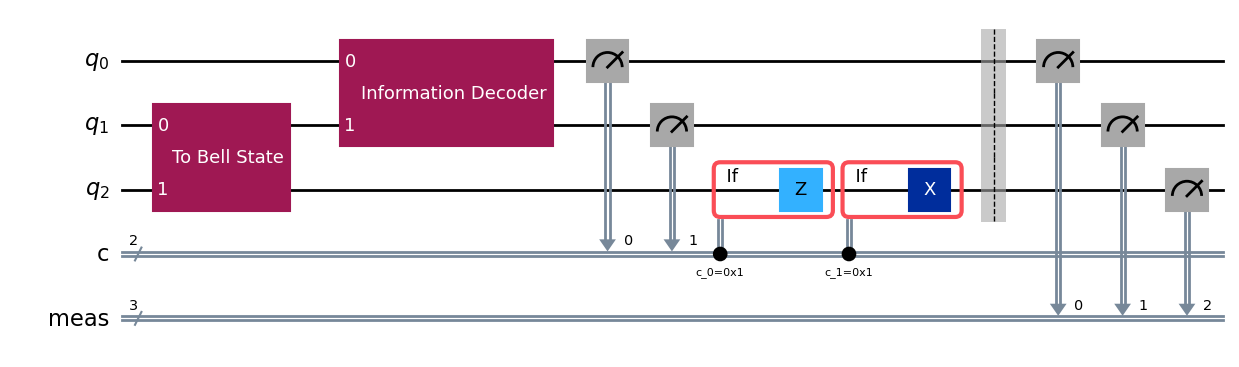

In [20]:
#Create quantum teleportation circuit, similar to the superdense coding circuit
def get_tel_circ():
    #Create the teleportation circuit circuit
    tel_circ = QuantumCircuit(3, 2, name = "Quantum Teleportation circuit")

    #Prepare a bell state gate
    bell_circ = get_bell_circ()

    #Prepare decoder gate
    dec_circ = get_decode_circ()

    #START circuit construction

    #entangle q2 w q1 as control
    tel_circ.append(bell_circ, [1, 2])

    #Decode the circuit
    tel_circ.append(dec_circ, [0, 1])

    #Collapse the first two qubits
    tel_circ.measure(0, 0)
    tel_circ.measure(1, 1)

    #Encode the 3rd qubit with alternating encoding pattern
    with tel_circ.if_test((0, 1)):
        tel_circ.z(2)
        
    with tel_circ.if_test((1, 1)):
        tel_circ.x(2)

    #Return the superdense coding circuit
    return tel_circ

#Create superdense coding circuit for sending 11
tc = get_tel_circ()
tc.measure_all()
tc.draw('mpl')

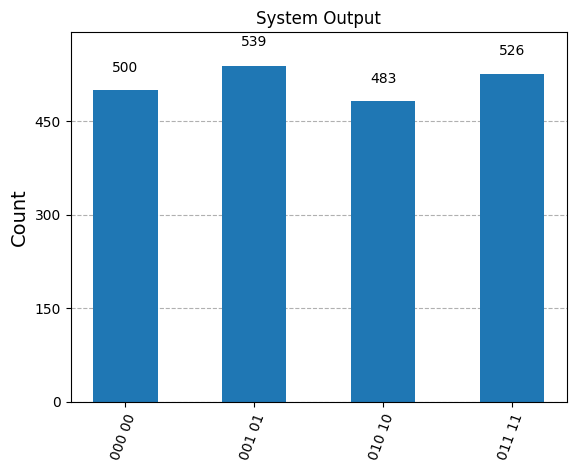

In [21]:
#Intialize the simulator
sim = AerSimulator(method = 'density_matrix', device = 'GPU')
iterations = 2048

#Transpile the circuit for the simulator to run
t_for_sim = transpile(tc, sim)
t_for_sim.draw('mpl')
 
# Run the transpiled circuit using the simulated backend
job = sim.run(t_for_sim, shots = iterations)
counts = job.result().get_counts()
plot_histogram(counts, title = "System Output")

In [33]:
#Assess simulator properties
print(sim.available_devices())
print(sim.available_methods())

('CPU', 'GPU')
('automatic', 'statevector', 'density_matrix', 'stabilizer', 'matrix_product_state', 'extended_stabilizer', 'unitary', 'superop', 'tensor_network')
